# **Predicting Nominal Power of Charging Stations**

## **Introduction**

Electric vehicles (EVs) have witnessed significant growth in Germany over the past few years, fueled by government subsidies, tax benefits, and an increasing demand for sustainable mobility solutions. Germany has emerged as a leader in the European EV market, with consumers opting for brands like Tesla, Volkswagen, BMW, and Mercedes-Benz. 

To support the growing EV adoption, the development of a robust and efficient charging infrastructure has become a critical requirement. Charging stations play a pivotal role in ensuring the usability and convenience of EVs, directly impacting their acceptance by consumers.

### **Objective**
This project focuses on predicting the **nominal power of charging stations (in kW)** based on:
- **Operator**: The organization or company managing the charging station.
- **Charging Points**: The number of charging outlets available.
- **Plug Types**: The types of connectors supported (e.g., Type 2, CHAdeMO, CCS).
- **Location**: The geographical location of the charging station.
- and many more features

### **Use Case**
The insights generated from this predictive model will:
1. Assist policymakers and urban planners in optimizing the deployment of charging infrastructure.
2. Provide a deeper understanding of the key drivers influencing charging station capacity.
3. Help in efficiently allocating resources to meet the rising demand for EV charging.

By enabling data-driven decision-making, this project aims to contribute to Germany's vision of sustainable transportation and reduced carbon emissions, supporting the nation's long-term climate goals.


# Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold
from collections import defaultdict
import geopandas as gpd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Loading and Exploring Data

In [2]:
#laod the data
df = pd.read_excel(r"E:\Study\THI\WS24\AI-AS\project_nominal_power\germany_e_charging_stations.xlsx")
df.head(5)

,operator,operator_type,number_of_charging_points,plug_type_1,plug_type_2,plug_type_3,p1_kw,p2_kw,p3_kw,nominal_power_of_charging_station_kw,city,place,pincode,street,house_number
0,ALDI SÜD,Standard Charger,2,AC socket type 2,AC socket type 2,NaN,22.0,22.0,NaN,44.0,Landkreis Bernkastel-Wittlich,Wittlich,54516,Römerstraße,59
1,Pfalzwerke AG,Standard Charger,2,AC socket type 2,AC socket type 2,NaN,22.0,22.0,NaN,22.0,Landkreis Bernkastel-Wittlich,WITTLICH,54516,Römerstraße,53
2,German Charge,Standard Charger,2,AC socket type 2,AC socket type 2,NaN,22.0,22.0,NaN,44.0,Landkreis Bernkastel-Wittlich,Manderscheid,54531,Gewerbestraße,6
3,EnBW mobility+ AG und Co.KG,Quick Charger,2,AC coupling type 2,"DC Coupler Combo, DC CHAdeMO",NaN,43.0,50.0,NaN,93.0,Landkreis Bernkastel-Wittlich,Niederöfflingen,54533,Autobahnraststätte Eifel West,0
4,IONITY GmbH,Quick Charger,1,DC clutch combo,NaN,NaN,350.0,NaN,NaN,350.0,Landkreis Bernkastel-Wittlich,Niederöfflingen,54533,Eifel Ost,0


In [3]:
#check the shape
df.shape

(54162, 15)

In [4]:
#check data types
print("\nData Types:")
print(df.dtypes)


Data Types:
operator                                 object
operator_type                            object
number_of_charging_points                 int64
plug_type_1                              object
plug_type_2                              object
plug_type_3                              object
p1_kw                                   float64
p2_kw                                   float64
p3_kw                                   float64
nominal_power_of_charging_station_kw    float64
city                                     object
place                                    object
pincode                                   int64
street                                   object
house_number                             object
dtype: object


In [5]:
#check missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
operator                                    2
operator_type                               3
number_of_charging_points                   0
plug_type_1                                 6
plug_type_2                              8932
plug_type_3                             50052
p1_kw                                       0
p2_kw                                    8930
p3_kw                                   50052
nominal_power_of_charging_station_kw        0
city                                        0
place                                       0
pincode                                     0
street                                      0
house_number                                0
dtype: int64


In [6]:
# getting basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54162 entries, 0 to 54161
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   operator                              54160 non-null  object 
 1   operator_type                         54159 non-null  object 
 2   number_of_charging_points             54162 non-null  int64  
 3   plug_type_1                           54156 non-null  object 
 4   plug_type_2                           45230 non-null  object 
 5   plug_type_3                           4110 non-null   object 
 6   p1_kw                                 54162 non-null  float64
 7   p2_kw                                 45232 non-null  float64
 8   p3_kw                                 4110 non-null   float64
 9   nominal_power_of_charging_station_kw  54162 non-null  float64
 10  city                                  54162 non-null  object 
 11  place          

In [7]:
# getting basic statistic summary
df.describe()

,number_of_charging_points,p1_kw,p2_kw,p3_kw,nominal_power_of_charging_station_kw,pincode
count,54162.000000,54162.000000,45232.000000,4110.000000,54162.000000,54162.000000
mean,1.951294,44.228706,46.198601,30.295024,58.357597,54217.025073
std,0.599470,69.568830,69.932204,41.988238,71.829341,27491.516616
min,1.000000,0.000000,2.000000,2.300000,1.000000,1011.000000
25%,2.000000,22.000000,22.000000,22.000000,22.000000,31061.000000
50%,2.000000,22.000000,22.000000,22.000000,44.000000,55273.000000
75%,2.000000,22.000000,22.000000,22.000000,44.000000,78478.250000
max,4.000000,625.000000,480.000000,1125.000000,1200.000000,99994.000000


# Drop Irrelevant Columns

In [8]:
def drop_columns(df, columns):
    """
    Removes the specified columns from the dataframe.

    Parameters:
    - df: DataFrame to operate on
    - columns: List of column names to be removed
    """
    df.drop(columns, axis=1, inplace=True)

# Example usage
columns_to_remove = ["pincode", "street", "house_number"]

# Drop specified columns
drop_columns(df, columns_to_remove)

# Display the first few rows of the modified DataFrame
df.head()


,operator,operator_type,number_of_charging_points,plug_type_1,plug_type_2,plug_type_3,p1_kw,p2_kw,p3_kw,nominal_power_of_charging_station_kw,city,place
0,ALDI SÜD,Standard Charger,2,AC socket type 2,AC socket type 2,NaN,22.0,22.0,NaN,44.0,Landkreis Bernkastel-Wittlich,Wittlich
1,Pfalzwerke AG,Standard Charger,2,AC socket type 2,AC socket type 2,NaN,22.0,22.0,NaN,22.0,Landkreis Bernkastel-Wittlich,WITTLICH
2,German Charge,Standard Charger,2,AC socket type 2,AC socket type 2,NaN,22.0,22.0,NaN,44.0,Landkreis Bernkastel-Wittlich,Manderscheid
3,EnBW mobility+ AG und Co.KG,Quick Charger,2,AC coupling type 2,"DC Coupler Combo, DC CHAdeMO",NaN,43.0,50.0,NaN,93.0,Landkreis Bernkastel-Wittlich,Niederöfflingen
4,IONITY GmbH,Quick Charger,1,DC clutch combo,NaN,NaN,350.0,NaN,NaN,350.0,Landkreis Bernkastel-Wittlich,Niederöfflingen


# Step 2: Handling Missing Values

In this dataset, we observe that several columns have missing values.

### **Strategy for Handling Missing Data**

1. **Columns with minimal missing values**:
    - For columns such as `operator`, `operator_type`, and `plug_type_1`, we have a small number of missing entries (2, 3, and 6 respectively). These can be safely dropped without significantly affecting the dataset.

2. **Columns with significant missing values**:
    - For columns like `plug_type_2`, `plug_type_3`, `p2_kw`, and `p3_kw`, where the missing values are substantial, we need a more thoughtful approach. Given the relationship between these features and the target variable (`nominal_power_of_charging_station_kw`), we can attempt to estimate the missing values using probabilistic distribution. This approach assumes that the missing values are randomly distributed and can be imputed based on the observed distribution of non-missing values.

3. **Filling missing values for `p2_kw` and `p3_kw`**:
    - For the `p2_kw` and `p3_kw` columns, we can calculate the **median** of the available values and use it to fill the missing entries. The median is a robust measure of central tendency that is less affected by outliers and ensures that the imputed values are consistent with the overall distribution.

By employing these strategies, we can effectively handle missing data.


In [9]:
def drop_columns_with_missing_values(df, columns):
    """
    Drops rows from the dataframe where any of the specified columns have missing values.
    """
    df.dropna(subset=columns, inplace=True)

def probabilistic_assignment(df, target_column, group_by_column):
    """
    Assigns missing values in the target_column using probabilistic distribution based on a group_by_column.
    """
    # Calculate probabilities for each unique value in the target_column based on group_by_column
    probabilities = (
        df[df[target_column].notnull()]
        .groupby(group_by_column)[target_column]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )

    def assign_value_based_on_probability(row):
        """
        Assigns a value to the target_column based on the probabilities calculated.
        """
        if pd.isnull(row[target_column]):
            group = row[group_by_column]
            if group in probabilities.index:
                plug_types = probabilities.loc[group].index
                plug_probs = probabilities.loc[group].values
                return np.random.choice(plug_types, p=plug_probs)
            else:
                return np.random.choice(probabilities.columns)  # Fallback to random assignment
        return row[target_column]

    # Apply the probabilistic assignment to the DataFrame
    df[target_column] = df.apply(assign_value_based_on_probability, axis=1)

def fill_missing_values_with_median(df, columns):
    """
    Fills missing values in the specified columns with the median value.
    """
    for column in columns:
        df[column].fillna(df[column].median(), inplace=True)

# main
columns_to_drop = ["operator", "operator_type", "plug_type_1"]
drop_columns_with_missing_values(df, columns_to_drop)

# Apply probabilistic assignment for plug_type_2 and plug_type_3 based on nominal_power_of_charging_station_kw
probabilistic_assignment(df, 'plug_type_2', 'nominal_power_of_charging_station_kw')
probabilistic_assignment(df, 'plug_type_3', 'nominal_power_of_charging_station_kw')

# Fill missing values for p2_kw and p3_kw with median
fill_missing_values_with_median(df, ['p2_kw', 'p3_kw'])

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
operator                                0
operator_type                           0
number_of_charging_points               0
plug_type_1                             0
plug_type_2                             0
plug_type_3                             0
p1_kw                                   0
p2_kw                                   0
p3_kw                                   0
nominal_power_of_charging_station_kw    0
city                                    0
place                                   0
dtype: int64


# Step 3: Outlier Handling

## **Outlier Strategies**

In this dataset, handling outliers is an important step to ensure the accuracy and reliability of our predictive model. We will address potential outliers in the various columns based on their nature and relationship with the target variable.

### **1. Columns with categorical values:**

- **operator**: 
    - As `operator` is a categorical feature, we will define a threshold for rare occurrences of operator names. If an operator appears only a few times (e.g., 2 occurrences), we can replace these rare values with a generic label such as "Other" to avoid skewing the model.
  
- **operator_type**: 
    - Since there are only two types for this feature, no action is needed regarding outliers. The feature is binary, and there are no outlier concerns here.

- **number_of_charging_points**:
    - This feature has only a few distinct values (4 values), so outliers are not a concern. We can leave this feature as it is.

- **plug_type_1, plug_type_2, plug_type_3**:
    - These are categorical variables. As such, they don't require outlier handling since the values represent different types of plugs. No further action is needed.

- **city and place**:
    - These are categorical variables, and no outlier handling is needed for them.

### **2. Columns with numerical values:**

- **p1_kw, p2_kw, p3_kw**:
    - These features are related to the nominal power of the charging stations. We will first check the correlation of each of these features with the target variable, `nominal_power_of_charging_station_kw`.
    - Based on the correlation and distribution analysis, we will decide whether any outliers need to be handled (e.g., using techniques such as winsorization or capping).

- **nominal_power_of_charging_station_kw**:
    - This is our target variable, and outliers here are generally indicative of invalid or incorrect values. We will analyze the statistical summary of this feature and decide on a strategy to handle any outliers, if present.

By addressing outliers carefully in these columns, we can improve the robustness of the model and ensure that extreme values do not disproportionately affect the predictions.


In [10]:
def categorize_rare_operators(df, column_name, threshold):
    """
    Replaces operators with fewer occurrences than the threshold with 'Other'.
    
    Parameters:
    - df: DataFrame to operate on
    - column_name: The column to check for rare values
    - threshold: The minimum count for a value to be considered common
    """
    # Get the counts of each operator
    operator_counts = df[column_name].value_counts()
    
    # Replace rare operators with 'Other'
    df[column_name] = df[column_name].apply(
        lambda operator: operator if operator_counts[operator] > threshold else 'Other'
    )

# Example usage
operator_threshold = 2
categorize_rare_operators(df, 'operator', operator_threshold)


In [11]:
def calculate_iqr(df, column_name):
    """
    Calculates the Interquartile Range (IQR) and the lower and upper bounds for outlier detection.

    Parameters:
    - df: DataFrame to operate on
    - column_name: The column to calculate IQR for

    Returns:
    - lower_bound: The lower bound for outlier detection
    - upper_bound: The upper bound for outlier detection
    """
    # Calculate the first (Q1) and third quartile (Q3)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return lower_bound, upper_bound

def print_correlation(df, columns):
    """
    Prints the correlation matrix for the specified columns in the dataframe.

    Parameters:
    - df: DataFrame to operate on
    - columns: List of column names to calculate correlation for
    """
    print(df[columns].corr())

def print_value_count_for_specific_value(df, column_name, value):
    """
    Prints the count of a specific value in a column.

    Parameters:
    - df: DataFrame to operate on
    - column_name: The column to count the specific value in
    - value: The specific value to count in the column
    """
    print(df[column_name].value_counts().loc[value])


In [12]:
#p1
column_name = "p1_kw"

# Print summary statistics
print(f"Summary statistics for {column_name}:")
print(df[column_name].describe())

# Calculate the IQR and bounds for outliers
lower_bound, upper_bound = calculate_iqr(df, column_name)

# Print the lower and upper bounds
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")


Summary statistics for p1_kw:
count    54154.000000
mean        44.230965
std         69.571015
min          1.000000
25%         22.000000
50%         22.000000
75%         22.000000
max        625.000000
Name: p1_kw, dtype: float64
Lower bound: 22.0, Upper bound: 22.0


In [13]:
#p1
columns_to_corr = ["p1_kw", "nominal_power_of_charging_station_kw"]

# Print correlation matrix for specified columns
print("Correlation between p1_kw and nominal_power_of_charging_station_kw:")
print_correlation(df, columns_to_corr)

# Print the count of value 625 in the "p1_kw" column
print("\nCount of value 625 in p1_kw:")
print_value_count_for_specific_value(df, "p1_kw", 625)

Correlation between p1_kw and nominal_power_of_charging_station_kw:
                                         p1_kw  \
p1_kw                                 1.000000   
nominal_power_of_charging_station_kw  0.944423   

                                      nominal_power_of_charging_station_kw  
p1_kw                                                             0.944423  
nominal_power_of_charging_station_kw                              1.000000  

Count of value 625 in p1_kw:
3


As we see that there is a high correlation and the value appears threee times it is a valid data entry and not an anomaly, it is imp for us to capture this realtionship and hence we dont drop it.

In [14]:
#p2
column_name = "p2_kw"

# Print summary statistics
print(f"Summary statistics for {column_name}:")
print(df[column_name].describe())

# Calculate the IQR and bounds for outliers
lower_bound, upper_bound = calculate_iqr(df, column_name)

# Print the lower and upper bounds
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Summary statistics for p2_kw:
count    54154.000000
mean        42.212535
std         64.539274
min          2.000000
25%         22.000000
50%         22.000000
75%         22.000000
max        480.000000
Name: p2_kw, dtype: float64
Lower bound: 22.0, Upper bound: 22.0


In [15]:
#p2
columns_to_corr = ["p2_kw", "nominal_power_of_charging_station_kw"]

# Print correlation matrix for specified columns
print("Correlation between p1_kw and nominal_power_of_charging_station_kw:")
print_correlation(df, columns_to_corr)

# Print the count of value 480 in the "p1_kw" column
print("\nCount of value 480 in p1_kw:")
print_value_count_for_specific_value(df, "p2_kw", 480)

Correlation between p1_kw and nominal_power_of_charging_station_kw:
                                         p2_kw  \
p2_kw                                 1.000000   
nominal_power_of_charging_station_kw  0.875028   

                                      nominal_power_of_charging_station_kw  
p2_kw                                                             0.875028  
nominal_power_of_charging_station_kw                              1.000000  

Count of value 480 in p1_kw:
1


As we see that there is a high correlation and the value appears a single time it is a valid data entry and not an anomaly, it is imp for us to capture this realtionship and hence we dont drop it.

In [16]:
#p3
column_name = "p3_kw"

# Print summary statistics
print(f"Summary statistics for {column_name}:")
print(df[column_name].describe())

# Calculate the IQR and bounds for outliers
lower_bound, upper_bound = calculate_iqr(df, column_name)

# Print the lower and upper bounds
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Summary statistics for p3_kw:
count    54154.000000
mean        22.627203
std         11.757893
min          2.300000
25%         22.000000
50%         22.000000
75%         22.000000
max       1125.000000
Name: p3_kw, dtype: float64
Lower bound: 22.0, Upper bound: 22.0


In [17]:
#p3
columns_to_corr = ["p3_kw", "nominal_power_of_charging_station_kw"]

# Print correlation matrix for specified columns
print("Correlation between p1_kw and nominal_power_of_charging_station_kw:")
print_correlation(df, columns_to_corr)

# Print the count of value 1125 in the "p1_kw" column
print("\nCount of value 1125 in p1_kw:")
print_value_count_for_specific_value(df, "p3_kw", 1125)

Correlation between p1_kw and nominal_power_of_charging_station_kw:
                                         p3_kw  \
p3_kw                                 1.000000   
nominal_power_of_charging_station_kw  0.146869   

                                      nominal_power_of_charging_station_kw  
p3_kw                                                             0.146869  
nominal_power_of_charging_station_kw                              1.000000  

Count of value 1125 in p1_kw:
2


The story with p3_kw is quite different a low correlation and rare occurance makes it an outlier and we can drop it so we dont add unnecessary noise and complexity to the model while predicting nominal_power

In [18]:
def remove_rows_by_value(df, column_name, value):
    """
    Removes rows from the dataframe where the specified column has a specific value.
    
    Parameters:
    - df: DataFrame to operate on
    - column_name: The column to check for the specific value
    - value: The value to check for in the specified column
    """
    df.drop(df[df[column_name] == value].index, inplace=True)

In [19]:
column_to_clean = "p3_kw"
value_to_remove = 1125

remove_rows_by_value(df, column_to_clean, value_to_remove)

In [20]:
#nominal_power_of_charging_station_kw
column_name = "nominal_power_of_charging_station_kw"

# Print summary statistics
print(f"Summary statistics for {column_name}:")
print(df[column_name].describe())

# Calculate the IQR and bounds for outliers
lower_bound, upper_bound = calculate_iqr(df, column_name)

# Print the lower and upper bounds
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Summary statistics for nominal_power_of_charging_station_kw:
count    54152.000000
mean        58.355548
std         71.826603
min          1.000000
25%         22.000000
50%         44.000000
75%         44.000000
max       1200.000000
Name: nominal_power_of_charging_station_kw, dtype: float64
Lower bound: -11.0, Upper bound: 77.0


In [21]:
print(df["nominal_power_of_charging_station_kw"].value_counts().loc[1200])

df[df["nominal_power_of_charging_station_kw"] == 1200]

2


,operator,operator_type,number_of_charging_points,plug_type_1,plug_type_2,plug_type_3,p1_kw,p2_kw,p3_kw,nominal_power_of_charging_station_kw,city,place
20039,Audi AG,Quick Charger,4,DC clutch combo,DC clutch combo,DC clutch combo,300.0,300.0,300.0,1200.0,Landkreis Heilbronn,Neckarsulm
22472,Audi AG,Quick Charger,4,DC clutch combo,DC clutch combo,DC clutch combo,300.0,300.0,300.0,1200.0,Kreisfreie Stadt Ingolstadt,Ingolstadt


The values are not outliers because there charging stations are legitimate

# Step 4: Encoding and Normalizing/Standardizing Data

## **Standardization / Encoding Strategies**

In this project, we will use different encoding and scaling techniques based on the characteristics of each feature. Below is a detailed explanation of the strategies for each feature:

### **1. Categorical Features:**

- **operator**: 
    - **Frequency Encoding**: Since `operator` has many unique values, we will use frequency encoding. This technique replaces the categories with the frequency of their occurrence in the dataset, helping to represent the relative importance of each category without introducing too many new features.

- **operator_type**:
    - **Label Encoding**: As `operator_type` has only 2 unique values (binary), label encoding is appropriate. It will assign numerical labels (0 or 1) to each category, making it suitable for machine learning models that can interpret numerical values.

- **plug_type_1, plug_type_2, plug_type_3**:
    - **Target Encoding**: These columns have 41, 35, and 35 unique values, respectively. Target encoding involves replacing each category with the mean of the target variable for that category. This technique captures the relationship between the categorical feature and the target variable, which can be useful for machine learning models.

- **city and place**:
    - **Frequency Encoding**: Both `city` and `place` have many unique values, and we don't have a clear relationship with the target variable. Frequency encoding is chosen for these features as it captures the frequency of categories and helps reduce the dimensionality when there are too many unique values.

### **2. Numerical Features:**

- **number_of_charging_points**:
    - No encoding needed as the feature has only 4 values, and the neural network (NN) is capable of understanding the ordinal nature (ranking) of this feature without requiring explicit transformation.

- **p1_kw, p2_kw, p3_kw**:
    - **Standardization**: These numerical features will be standardized to have a mean of 0 and a standard deviation of 1. Standardization is particularly useful when the data is not uniformly distributed or contains outliers, as it doesn't bound the values within a fixed range.

- **nominal_power_of_charging_station_kw**:
    - **MinMax Scaling**: For the target variable `nominal_power_of_charging_station_kw`, we will apply MinMax scaling. This scaling technique transforms the data to a fixed range (usually 0 to 1), making it suitable for models that require positive values and need to operate within a certain range.

By using these strategies, we ensure that each feature is appropriately encoded or scaled, enabling the model to learn from the data effectively while preserving meaningful patterns.


In [22]:
def frequency_encoding(df, columns):
    """
    Applies frequency encoding to categorical columns in the dataframe.
    
    Parameters:
    - df: DataFrame to operate on
    - columns: List of column names to apply frequency encoding
    
    Returns:
    - df: DataFrame with frequency encoded columns
    """
    for col in columns:
        freq = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq)
    return df

def label_encoding(df, column):
    """
    Applies label encoding to a specific column in the dataframe.
    
    Parameters:
    - df: DataFrame to operate on
    - column: Column name to apply label encoding
    
    Returns:
    - df: DataFrame with label encoded column
    """
    label_encoder = LabelEncoder()
    df[column] = label_encoder.fit_transform(df[column])
    return df

def target_encoding_leakage_free(df, column_name, target_name, n_splits=5):
    """
    Applies target encoding with data leakage prevention to a column in the dataframe.
    
    Parameters:
    - df: DataFrame to operate on
    - column_name: Column to encode
    - target_name: Target column to calculate means
    - n_splits: Number of splits for cross-validation
    
    Returns:
    - encoded_column: Series of target encoded values
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    encoded_column = pd.Series(index=df.index, dtype=float)

    for train_idx, val_idx in kf.split(df):
        train_data, val_data = df.iloc[train_idx], df.iloc[val_idx]
        target_mean = train_data.groupby(column_name)[target_name].mean()
        encoded_column.iloc[val_idx] = val_data[column_name].map(target_mean)
    
    global_mean = df[target_name].mean()
    encoded_column = encoded_column.fillna(global_mean)
    
    return encoded_column

def min_max_scaling(df, columns):
    """
    Applies MinMax scaling to numerical columns in the dataframe.
    
    Parameters:
    - df: DataFrame to operate on
    - columns: List of numerical columns to apply MinMax scaling
    
    Returns:
    - df: DataFrame with scaled columns
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[columns] = scaler.fit_transform(df[columns])
    return df

# Main processing
df_model_building = df.copy()

# 1. Apply Frequency Encoding
categorical_columns = ["operator", "city", "place"]
df_model_building = frequency_encoding(df_model_building, categorical_columns)

# 2. Apply Label Encoding
df_model_building = label_encoding(df_model_building, "operator_type")

# 3. Apply Target Encoding
target_column = "nominal_power_of_charging_station_kw"
target_columns = ["plug_type_1", "plug_type_2", "plug_type_3"]
for col in target_columns:
    df_model_building[col] = target_encoding_leakage_free(df_model_building, col, target_column)

# 4. Apply MinMax Scaling
numerical_columns = ["p1_kw", "p2_kw", "p3_kw", "nominal_power_of_charging_station_kw"]
df_model_building = min_max_scaling(df_model_building, numerical_columns)

# Check the final output
df_model_building.head()

,operator,operator_type,number_of_charging_points,plug_type_1,plug_type_2,plug_type_3,p1_kw,p2_kw,p3_kw,nominal_power_of_charging_station_kw,city,place
0,0.010748,1,2,32.273567,33.019711,30.983183,0.033654,0.041841,0.055074,0.035863,0.001588,0.000406
1,0.011228,1,2,32.273567,33.019711,30.983183,0.033654,0.041841,0.055074,0.017515,0.001588,0.000055
2,0.000314,1,2,32.268152,33.015952,30.975456,0.033654,0.041841,0.055074,0.035863,0.001588,0.000037
3,0.054033,0,2,41.010918,95.879677,80.513274,0.067308,0.100418,0.055074,0.076731,0.001588,0.000074
4,0.003065,0,1,174.287217,193.760968,217.069669,0.559295,0.041841,0.055074,0.291076,0.001588,0.000074


# Step 5: Model Building

## **Model Architecture and Training Process**

### **Model Architecture**

We will design a fully connected feedforward neural network with the following components:

#### **1. Input Layer:**
The input layer will match the number of input features (columns in our dataset). Each feature will be fed into the model to provide the necessary data for prediction.

#### **2. Hidden Layers:**
- We will add multiple hidden layers of neurons to capture complex relationships between the input features and the target variable.
- The **ReLU (Rectified Linear Unit)** activation function will be used in the hidden layers to introduce non-linearity, allowing the model to learn more complex patterns and interactions in the data.
- **Dropout** will be applied in the hidden layers to reduce the risk of overfitting, ensuring the model generalizes well to new, unseen data.

#### **3. Output Layer:**
The output layer will consist of a single neuron, as we are predicting a single continuous target variable (`nominal_power_of_charging_station_kw`).

### **Loss Function and Optimizer**
- **Loss Function**: We will use **Mean Squared Error (MSE)** as the loss function. MSE penalizes large prediction errors more than smaller ones, which is suitable for regression tasks where we aim to minimize prediction errors.
- **Optimizer**: We will use the **Adam optimizer**, which adapts the learning rate during training for faster and more stable convergence. Adam is a popular choice due to its efficiency in handling complex models.

---

### **Training the Model**

#### **1. Epochs:**
The model will be trained over multiple iterations (epochs), where it will attempt to minimize the loss (MSE) by updating its weights through backpropagation. Each epoch represents a complete pass through the training data.

#### **2. Validation Loss:**
After each epoch, we will check the model’s performance on the validation set to ensure it is not overfitting or underfitting. This allows us to monitor whether the model is generalizing well to unseen data during training.

#### **3. Batching:**
The training data will be divided into small batches, which will speed up the training process. Batching allows for more efficient weight updates and helps improve model performance.

---

### **Model Evaluation**

After training, we will evaluate the model's performance on the test set using the following metrics:

#### **1. MSE (Mean Squared Error):**
This will measure the average squared difference between predicted and actual values. A smaller MSE indicates better performance.

#### **2. MAE (Mean Absolute Error):**
This will measure the average absolute difference between predicted and actual values. MAE is easier to interpret than MSE, as it provides an estimate of the average magnitude of errors.

#### **3. R² Score:**
This will tell us how much variance in the target variable (`nominal_power_of_charging_station_kw`) is explained by the model. An R² score closer to 1 will indicate that the model has explained most of the variance in the target variable.

With these steps, we will ensure that the model is trained effectively, evaluated accurately, and ready to make reliable predictions on new data.


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/100 - Train Loss: 0.0151, Val Loss: 0.0043
Epoch 2/100 - Train Loss: 0.0027, Val Loss: 0.0012
Epoch 3/100 - Train Loss: 0.0015, Val Loss: 0.0013
Epoch 4/100 - Train Loss: 0.0011, Val Loss: 0.0010
Epoch 5/100 - Train Loss: 0.0009, Val Loss: 0.0009
Epoch 6/100 - Train Loss: 0.0007, Val Loss: 0.0008
Epoch 7/100 - Train Loss: 0.0006, Val Loss: 0.0008
Epoch 8/100 - Train Loss: 0.0005, Val Loss: 0.0007
Epoch 9/100 - Train Loss: 0.0005, Val Loss: 0.0007
Epoch 10/100 - Train Loss: 0.0004, Val Loss: 0.0007
Epoch 11/100 - Train Loss: 0.0004, Val Loss: 0.0007
Epoch 12/100 - Train Loss: 0.0004, Val Loss: 0.0005
Epoch 13/100 - Train Loss: 0.0004, Val Loss: 0.0006
Epoch 14/100 - Train Loss: 0.0004, Val Loss: 0.0005
Epoch 15/100 - Train Loss: 0.0004, Val Loss: 0.0005
Epoch 16/100 - Train Loss: 0.0004, Val Loss: 0.0005
Epoch 17/100 - Train Loss: 0.0004, Val Loss: 0.0006
Epoch 18/100 - Train Loss: 0.0003, Val Loss: 0.0005
Epoch 19/100 - Train Loss: 0.0004, Val Loss: 0.0005
Epoch 20/100 - Train 

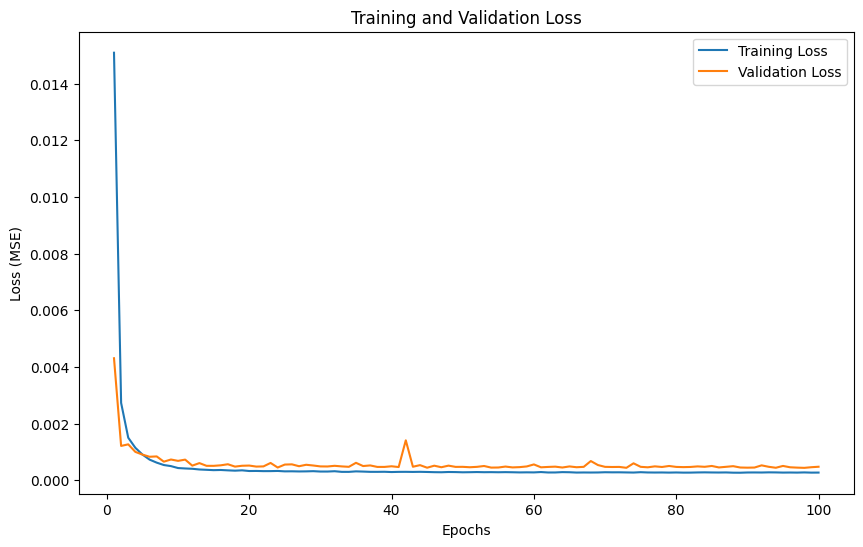

Test Loss (MSE): 0.0002
Mean Squared Error (MSE): 0.0002
Mean Absolute Error (MAE): 0.0084
R² Score: 0.9289


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Dataset Preparation
class ChargingStationDataset(Dataset):
    def __init__(self, data, target_column):
        """
        PyTorch Dataset for Charging Station Data
        """
        self.X = data.drop(columns=[target_column]).values.astype(np.float32)
        self.y = data[target_column].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def prepare_data(data, target_column, batch_size=32):
    """
    Prepares DataLoaders for training, validation, and testing
    """
    dataset = ChargingStationDataset(data, target_column)

    # Split dataset into train, validation, and test sets
    train_size = int(0.8 * len(dataset))
    val_size = int(0.1 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# Model Definition
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        """
        A simple feedforward neural network for regression
        """
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Linear output for regression
        )

    def forward(self, x):
        return self.model(x)


# Training and Validation Loop
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, device, epochs=100):
    """
    Trains the model and evaluates on the validation and test sets
    """
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).squeeze()
                loss = criterion(predictions, y_batch)
                val_loss += loss.item()

        # Test phase
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).squeeze()
                loss = criterion(predictions, y_batch)
                test_loss += loss.item()

        # Record average losses
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        test_loss /= len(test_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, val_losses, test_losses



# Evaluation
def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluates the model on the test set
    """
    model.eval()
    test_loss = 0
    predictions, actuals = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            preds = model(X_batch).squeeze()
            loss = criterion(preds, y_batch)

            test_loss += loss.item()
            predictions.extend(preds.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    test_loss /= len(test_loader)
    return test_loss, np.array(predictions), np.array(actuals)


# Main Script
def main():
    # Assuming `df_model_building` is your DataFrame
    data = df_model_building
    target_column = 'nominal_power_of_charging_station_kw'

    # Prepare data
    batch_size = 32
    train_loader, val_loader, test_loader = prepare_data(data, target_column, batch_size)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model, loss, and optimizer
    input_dim = data.shape[1] - 1  # Number of input features
    model = NeuralNetwork(input_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    epochs = 100
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)

    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

    # Evaluate on test set
    test_loss, y_pred, y_actual = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss (MSE): {test_loss:.4f}")

    
    # Inverse transform predictions (if required)
    scaler = MinMaxScaler()
    scaler.fit(data[[target_column]])
    y_actual_original = scaler.inverse_transform(y_actual.reshape(-1, 1))
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Compute metrics
    mse = mean_squared_error(y_actual_original, y_pred_original)
    mae = mean_absolute_error(y_actual_original, y_pred_original)
    r2 = r2_score(y_actual_original, y_pred_original)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")


if __name__ == "__main__":
    main()
